# Imports

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Nico\AppData\Local\Temp\ipykernel_2444\115576343.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Transformacion de las imagenes

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionamos las imágenes a 128x128
    transforms.ToTensor(),            # Convertimos las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizamos con media 0.5 y desviación estándar 0.5
])

# Cargamos el dataset de Rock, Paper, Scissors
dataset_path = 'primera_practica2/Flags'  # Cambia esto a la ruta donde descargaste el dataset
train_data = datasets.ImageFolder(root=dataset_path, transform=transform)

# Calcular el tamaño del conjunto de datos
dataset_size = len(train_data)

# Definir proporciones para dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Dividir el dataset en entrenamiento y prueba
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])

# Crear DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Imprimir el número de clases y sus nombres
class_names = train_data.classes
print(f'Clases encontradas: {class_names}')
print(f"Numero de clases: {len(class_names)}")
print(f'Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}')
print(f'Tamaño del conjunto de prueba: {len(test_loader.dataset)}')

Clases encontradas: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Holland', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Slovakia', 'Slovenia', 'South Cyprus', 'Spain', 'Sweden']
Numero de clases: 24
Tamaño del conjunto de entrenamiento: 796
Tamaño del conjunto de prueba: 200


# Modelo

In [3]:
class ConvNet(nn.Module):
    def __init__(self, num_filters_conv1=16, num_filters_conv2=32, kernel_size_conv1=5, kernel_size_conv2=5,
                 fc1_units=120, fc2_units=24, dropout_rate=0.0, activation=nn.ReLU):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters_conv1, kernel_size=kernel_size_conv1, stride=1, padding=kernel_size_conv1 // 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, kernel_size=kernel_size_conv2, stride=1, padding=kernel_size_conv2 // 2)
        
        self.fc1 = nn.Linear(num_filters_conv2 * 32 * 32, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation()  # Instancia de la función de activación

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Aplanar
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x

# Entrenamiento básico

In [ ]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Entrenamiento
    model.train()  # Establecer el modelo en modo de entrenamiento
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Obtenemos las predicciones
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Promedio de la pérdida
    average_loss = running_loss / len(train_loader)
    
    # Calcular precisión
    accuracy = 100 * correct / total
    
    # Imprimir resultados
    print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1, Loss: 2.2154, Accuracy: 34.42%
Epoch 2, Loss: 0.8506, Accuracy: 75.25%
Epoch 3, Loss: 0.4617, Accuracy: 87.69%
Epoch 4, Loss: 0.3009, Accuracy: 91.96%
Epoch 5, Loss: 0.1536, Accuracy: 95.98%


# Testeo básico

In [23]:
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model: {100 * correct / total}%')

Accuracy of the model: 82.0%


# Validacion de hiperparametros

In [8]:
# Función para definir el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def create_model(trial):
    # Sugerir valores de hiperparámetros para el modelo
    num_filters_conv1 = trial.suggest_int('num_filters_conv1', 8, 64, step=8)
    num_filters_conv2 = trial.suggest_int('num_filters_conv2', 16, 128, step=16)
    kernel_size_conv1 = trial.suggest_int('kernel_size_conv1', 3, 7, step=2)
    kernel_size_conv2 = trial.suggest_int('kernel_size_conv2', 3, 7, step=2)
    fc1_units = trial.suggest_int('fc1_units', 64, 512, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    activation = trial.suggest_categorical('activation', [nn.ReLU, nn.LeakyReLU, nn.ELU, nn.Sigmoid, nn.Tanh])
    
    # Crear el modelo con los hiperparámetros sugeridos
    model = ConvNet(
        num_filters_conv1=num_filters_conv1,
        num_filters_conv2=num_filters_conv2,
        kernel_size_conv1=kernel_size_conv1,
        kernel_size_conv2=kernel_size_conv2,
        fc1_units=fc1_units,
        dropout_rate=dropout_rate,
        activation=activation
    ).to(device)
    
    # Sugerir el learning rate y el optimizador
    learning_rate = trial.suggest_loguniform('lr', 0.00001, 0.001)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'ASGD', 'NAdam'])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    return model, optimizer

# Función de entrenamiento
def train_model(trial):
    model, optimizer = create_model(trial)
    criterion = nn.CrossEntropyLoss()
    
    # Hiperparámetros
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)  # Tamaño de lote
    epochs = 5
    
    # Crear DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Evaluar el modelo
    accuracy = evaluate_model(model, test_loader)
    
    return accuracy  # Devuelve la métrica que se quiere optimizar

# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Mueve los datos al dispositivo
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(train_model, n_trials=10)

[I 2024-12-02 17:33:15,636] A new study created in memory with name: no-name-bce07f96-7bea-429c-a0cd-4b891795ead5
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.LeakyReLU'> which is of type type.
  warnings.warn(message)
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persiste

# Obtencion de hiperparametros

In [5]:
lr_list = []
batch_size_list = []
num_filters_conv1_list = []
num_filters_conv2_list = []
kernel_size_conv1_list = []
kernel_size_conv2_list = []
fc1_units_list = []
dropout_rate_list = []
activation_list = []
optimizer_list = []
accuracy_list = []

for trial in study.trials:
    # Obtener el valor de la precisión (o cualquier otra métrica de validación)
    accuracy = trial.value
    
    # Obtener los hiperparámetros sugeridos para cada prueba
    num_filters_conv1 = trial.params['num_filters_conv1']
    num_filters_conv2 = trial.params['num_filters_conv2']
    kernel_size_conv1 = trial.params['kernel_size_conv1']
    kernel_size_conv2 = trial.params['kernel_size_conv2']
    fc1_units = trial.params['fc1_units']
    dropout_rate = trial.params['dropout_rate']
    activation = trial.params['activation']
    lr = trial.params['lr']
    optimizer = trial.params['optimizer']
    batch_size = trial.params['batch_size']
    
    # Almacenar los resultados en las listas
    lr_list.append(lr)
    batch_size_list.append(batch_size)
    num_filters_conv1_list.append(num_filters_conv1)
    num_filters_conv2_list.append(num_filters_conv2)
    kernel_size_conv1_list.append(kernel_size_conv1)
    kernel_size_conv2_list.append(kernel_size_conv2)
    fc1_units_list.append(fc1_units)
    dropout_rate_list.append(dropout_rate)
    activation_list.append(activation)
    optimizer_list.append(optimizer)
    accuracy_list.append(accuracy)

# Crear un DataFrame para visualizar los resultados
results_df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'LR': lr_list,
    'Batch Size': batch_size_list,
    'Num Filters Conv1': num_filters_conv1_list,
    'Num Filters Conv2': num_filters_conv2_list,
    'Kernel Size Conv1': kernel_size_conv1_list,
    'Kernel Size Conv2': kernel_size_conv2_list,
    'FC1 Units': fc1_units_list,
    'Dropout Rate': dropout_rate_list,
    'Activation': activation_list,
    'Optimizer': optimizer_list
})

# Mostrar el DataFrame
# Definir el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(results_df)

   Accuracy        LR  Batch Size  Num Filters Conv1  Num Filters Conv2  \
0     0.585  0.000137          96                 16                 48   
1     0.595  0.000823          16                 56                112   
2     0.715  0.000129          96                 48                128   
3     0.640  0.000049          80                 40                 64   
4     0.730  0.000027          16                 32                128   
5     0.610  0.000247          96                 32                 96   
6     0.470  0.000012         112                 40                128   
7     0.035  0.000015         112                  8                 16   
8     0.525  0.000646          16                 64                 80   
9     0.725  0.000257          64                 40                 80   

   Kernel Size Conv1  Kernel Size Conv2  FC1 Units  Dropout Rate  \
0                  7                  5        128      0.217178   
1                  3                  

# Entrenamiento y test con graficos y aprendizaje por transferencia

Epoch 1/10, Loss: 2.9667, Train Accuracy: 17.71%, Test Accuracy: 36.50%
Epoch 2/10, Loss: 2.2046, Train Accuracy: 41.58%, Test Accuracy: 54.50%
Epoch 3/10, Loss: 1.5665, Train Accuracy: 53.27%, Test Accuracy: 61.00%
Epoch 4/10, Loss: 1.2639, Train Accuracy: 65.95%, Test Accuracy: 63.00%
Epoch 5/10, Loss: 1.0646, Train Accuracy: 70.23%, Test Accuracy: 68.50%
Epoch 6/10, Loss: 0.8859, Train Accuracy: 75.38%, Test Accuracy: 70.50%
Epoch 7/10, Loss: 0.7311, Train Accuracy: 80.90%, Test Accuracy: 72.00%
Epoch 8/10, Loss: 0.5747, Train Accuracy: 84.17%, Test Accuracy: 74.50%
Epoch 9/10, Loss: 0.4989, Train Accuracy: 85.68%, Test Accuracy: 75.00%
Epoch 10/10, Loss: 0.4431, Train Accuracy: 88.57%, Test Accuracy: 78.00%


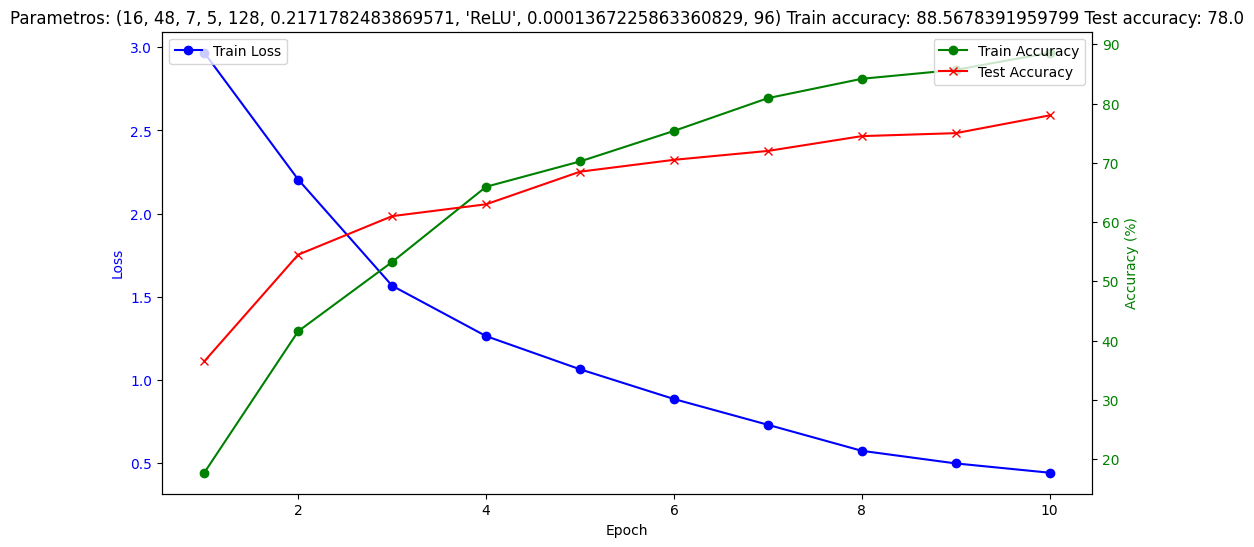

Epoch 1/10, Loss: 3.3431, Train Accuracy: 30.65%, Test Accuracy: 47.00%
Epoch 2/10, Loss: 1.4789, Train Accuracy: 58.67%, Test Accuracy: 67.50%
Epoch 3/10, Loss: 1.4475, Train Accuracy: 65.83%, Test Accuracy: 58.50%
Epoch 4/10, Loss: 1.0946, Train Accuracy: 69.10%, Test Accuracy: 71.50%
Epoch 5/10, Loss: 0.8035, Train Accuracy: 76.38%, Test Accuracy: 81.50%
Epoch 6/10, Loss: 0.5722, Train Accuracy: 84.17%, Test Accuracy: 73.00%
Epoch 7/10, Loss: 0.5473, Train Accuracy: 86.31%, Test Accuracy: 80.00%
Epoch 8/10, Loss: 0.3985, Train Accuracy: 88.44%, Test Accuracy: 81.50%
Deteniendo entrenamiento: No hubo mejora en las últimas 3 épocas.


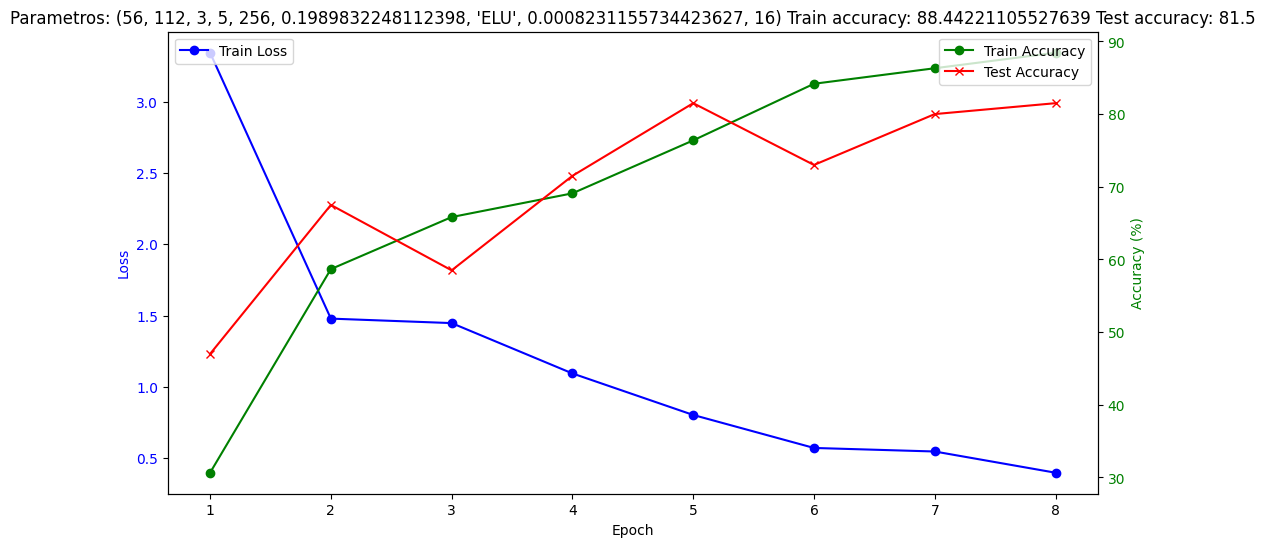

Epoch 1/10, Loss: 2.6421, Train Accuracy: 22.11%, Test Accuracy: 52.00%
Epoch 2/10, Loss: 1.4617, Train Accuracy: 59.05%, Test Accuracy: 68.50%
Epoch 3/10, Loss: 0.9234, Train Accuracy: 73.37%, Test Accuracy: 73.00%
Epoch 4/10, Loss: 0.7536, Train Accuracy: 80.15%, Test Accuracy: 78.50%
Epoch 5/10, Loss: 0.5198, Train Accuracy: 85.68%, Test Accuracy: 79.00%
Epoch 6/10, Loss: 0.4443, Train Accuracy: 85.68%, Test Accuracy: 79.50%
Epoch 7/10, Loss: 0.3643, Train Accuracy: 90.83%, Test Accuracy: 79.50%
Epoch 8/10, Loss: 0.2180, Train Accuracy: 94.85%, Test Accuracy: 81.50%
Epoch 9/10, Loss: 0.1805, Train Accuracy: 95.85%, Test Accuracy: 86.00%
Epoch 10/10, Loss: 0.1294, Train Accuracy: 96.98%, Test Accuracy: 87.00%


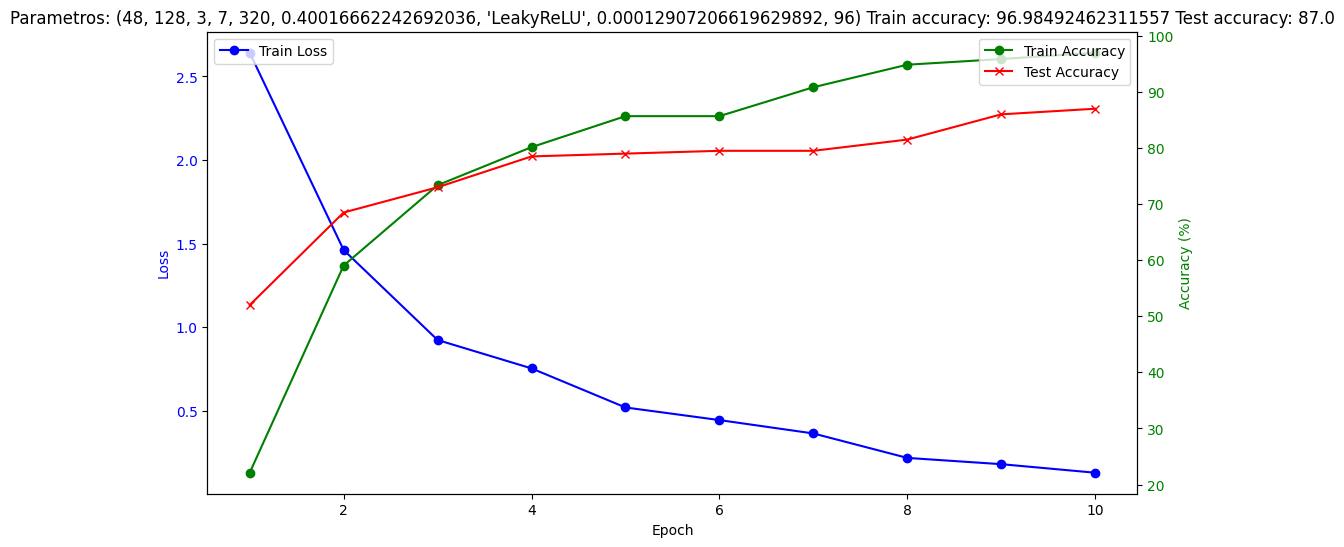

Epoch 1/10, Loss: 2.4811, Train Accuracy: 29.65%, Test Accuracy: 52.00%
Epoch 2/10, Loss: 1.4822, Train Accuracy: 61.56%, Test Accuracy: 62.50%
Epoch 3/10, Loss: 1.0709, Train Accuracy: 74.25%, Test Accuracy: 67.00%
Epoch 4/10, Loss: 0.8288, Train Accuracy: 81.78%, Test Accuracy: 73.50%
Epoch 5/10, Loss: 0.6551, Train Accuracy: 85.68%, Test Accuracy: 72.50%
Epoch 6/10, Loss: 0.5279, Train Accuracy: 88.19%, Test Accuracy: 73.50%
Epoch 7/10, Loss: 0.4277, Train Accuracy: 91.33%, Test Accuracy: 75.00%
Epoch 8/10, Loss: 0.3454, Train Accuracy: 94.22%, Test Accuracy: 74.00%
Epoch 9/10, Loss: 0.2720, Train Accuracy: 95.23%, Test Accuracy: 76.50%
Epoch 10/10, Loss: 0.2268, Train Accuracy: 96.48%, Test Accuracy: 76.00%


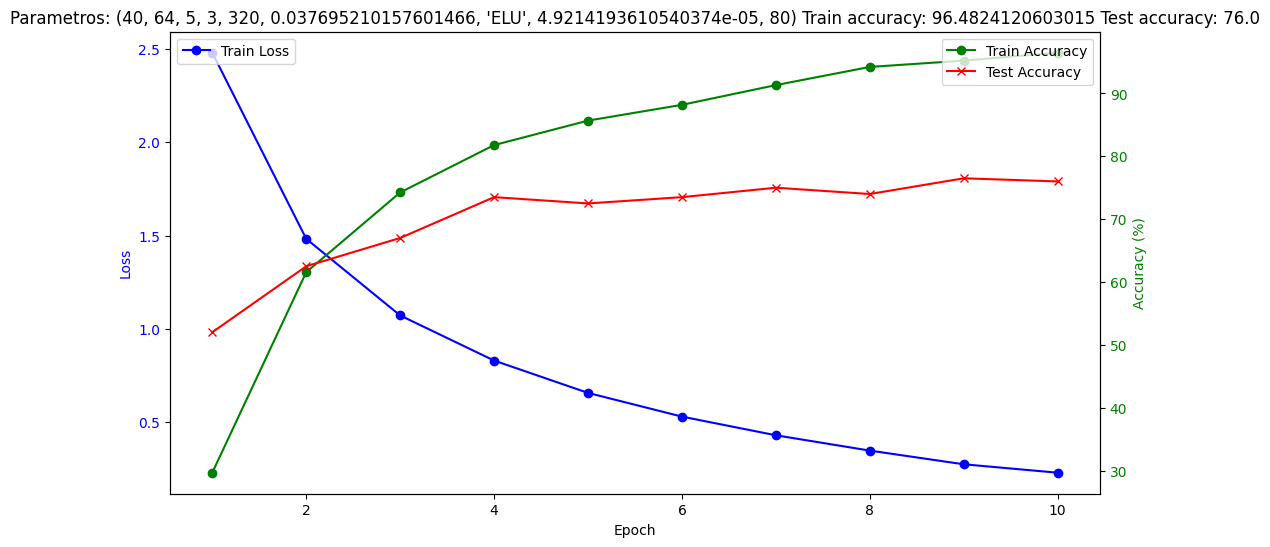

Epoch 1/10, Loss: 2.6320, Train Accuracy: 29.27%, Test Accuracy: 50.00%
Epoch 2/10, Loss: 1.2951, Train Accuracy: 65.45%, Test Accuracy: 68.00%
Epoch 3/10, Loss: 0.8284, Train Accuracy: 77.39%, Test Accuracy: 74.50%
Epoch 4/10, Loss: 0.5725, Train Accuracy: 85.05%, Test Accuracy: 79.50%
Epoch 5/10, Loss: 0.4384, Train Accuracy: 89.45%, Test Accuracy: 81.50%
Epoch 6/10, Loss: 0.3128, Train Accuracy: 93.09%, Test Accuracy: 79.50%
Epoch 7/10, Loss: 0.2559, Train Accuracy: 93.47%, Test Accuracy: 82.00%
Epoch 8/10, Loss: 0.1728, Train Accuracy: 96.23%, Test Accuracy: 83.00%
Epoch 9/10, Loss: 0.1384, Train Accuracy: 96.73%, Test Accuracy: 81.50%
Epoch 10/10, Loss: 0.1513, Train Accuracy: 97.36%, Test Accuracy: 82.50%


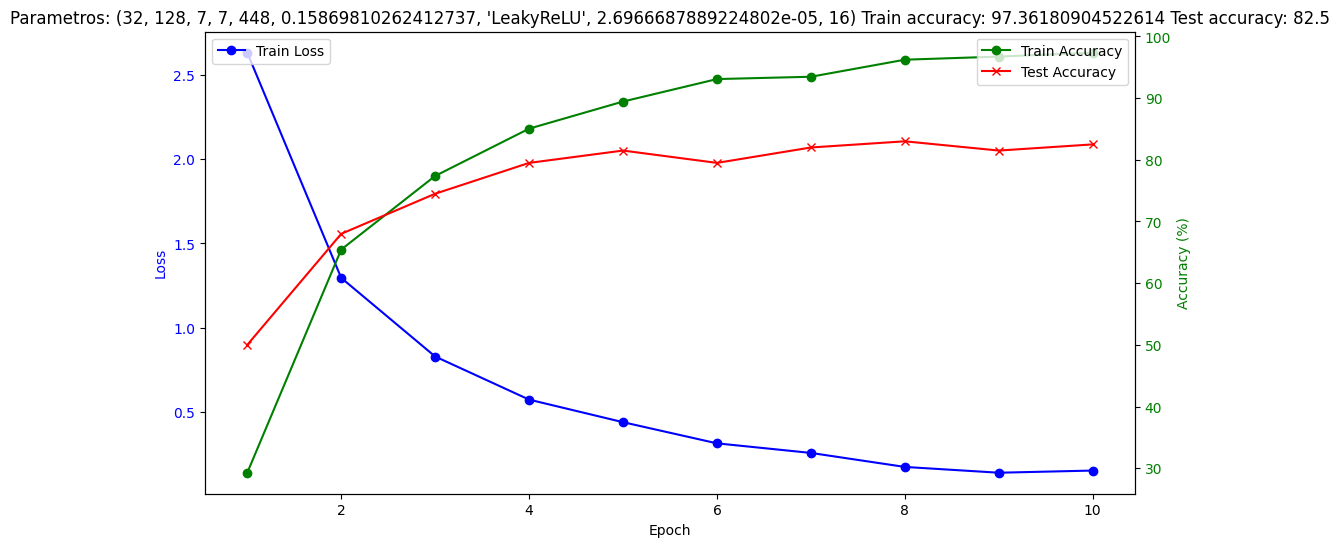

Epoch 1/10, Loss: 2.5900, Train Accuracy: 28.39%, Test Accuracy: 50.50%
Epoch 2/10, Loss: 1.4899, Train Accuracy: 56.91%, Test Accuracy: 66.00%
Epoch 3/10, Loss: 0.9792, Train Accuracy: 70.35%, Test Accuracy: 71.50%
Epoch 4/10, Loss: 0.7427, Train Accuracy: 78.52%, Test Accuracy: 76.00%
Epoch 5/10, Loss: 0.5931, Train Accuracy: 86.06%, Test Accuracy: 74.00%
Epoch 6/10, Loss: 0.4495, Train Accuracy: 88.07%, Test Accuracy: 78.00%
Epoch 7/10, Loss: 0.3559, Train Accuracy: 92.21%, Test Accuracy: 78.50%
Epoch 8/10, Loss: 0.2618, Train Accuracy: 93.47%, Test Accuracy: 77.00%
Epoch 9/10, Loss: 0.2350, Train Accuracy: 94.10%, Test Accuracy: 79.00%
Epoch 10/10, Loss: 0.2096, Train Accuracy: 94.72%, Test Accuracy: 78.50%


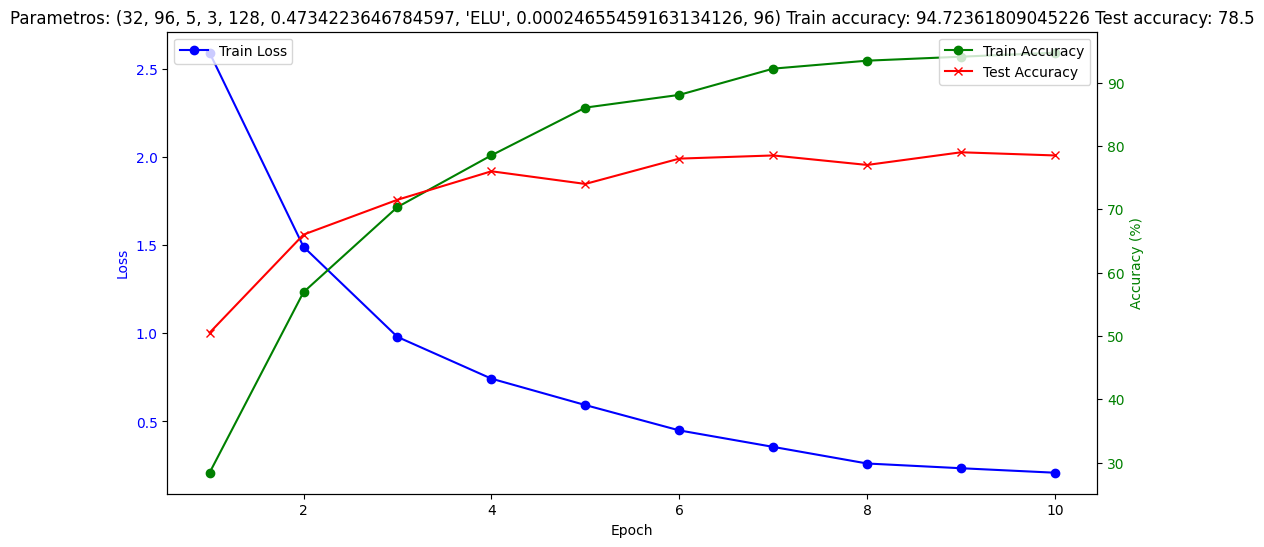

Epoch 1/10, Loss: 2.9886, Train Accuracy: 18.72%, Test Accuracy: 36.50%
Epoch 2/10, Loss: 2.5820, Train Accuracy: 39.07%, Test Accuracy: 42.00%
Epoch 3/10, Loss: 2.2345, Train Accuracy: 44.10%, Test Accuracy: 46.50%
Epoch 4/10, Loss: 2.0574, Train Accuracy: 50.00%, Test Accuracy: 50.50%
Epoch 5/10, Loss: 1.8709, Train Accuracy: 54.52%, Test Accuracy: 53.00%
Epoch 6/10, Loss: 1.6889, Train Accuracy: 58.79%, Test Accuracy: 54.00%
Epoch 7/10, Loss: 1.5391, Train Accuracy: 62.81%, Test Accuracy: 58.00%
Epoch 8/10, Loss: 1.4261, Train Accuracy: 63.94%, Test Accuracy: 58.00%
Epoch 9/10, Loss: 1.3440, Train Accuracy: 64.07%, Test Accuracy: 61.00%
Epoch 10/10, Loss: 1.2283, Train Accuracy: 68.97%, Test Accuracy: 64.00%


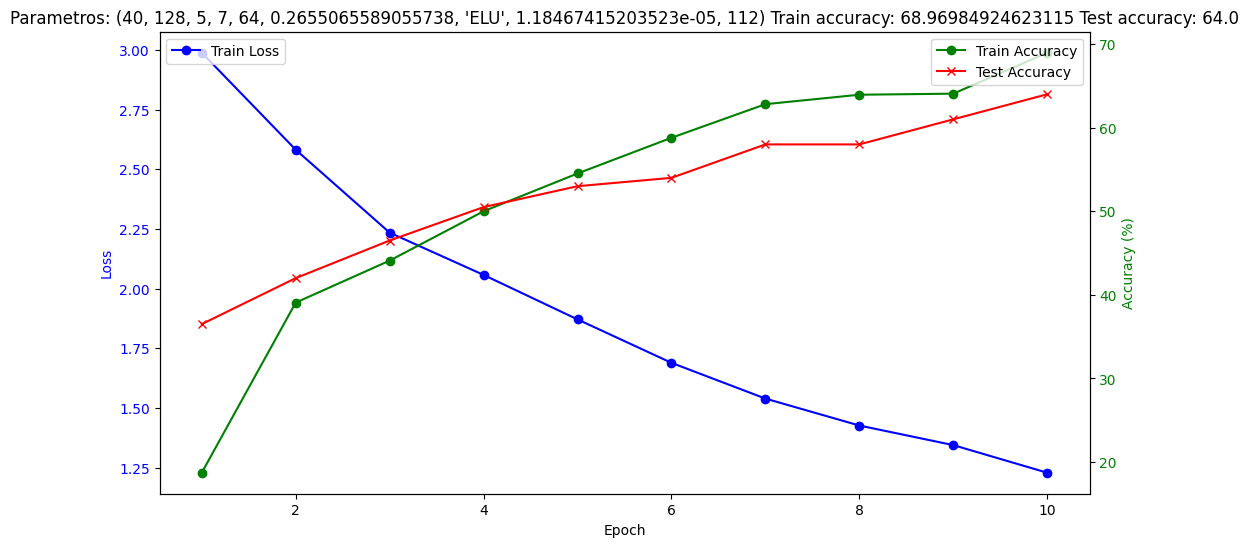

Epoch 1/10, Loss: 3.2250, Train Accuracy: 3.77%, Test Accuracy: 5.50%
Epoch 2/10, Loss: 3.1897, Train Accuracy: 4.15%, Test Accuracy: 3.00%
Epoch 3/10, Loss: 3.1787, Train Accuracy: 4.77%, Test Accuracy: 3.00%
Epoch 4/10, Loss: 3.1926, Train Accuracy: 4.15%, Test Accuracy: 5.50%
Deteniendo entrenamiento: No hubo mejora en las últimas 3 épocas.


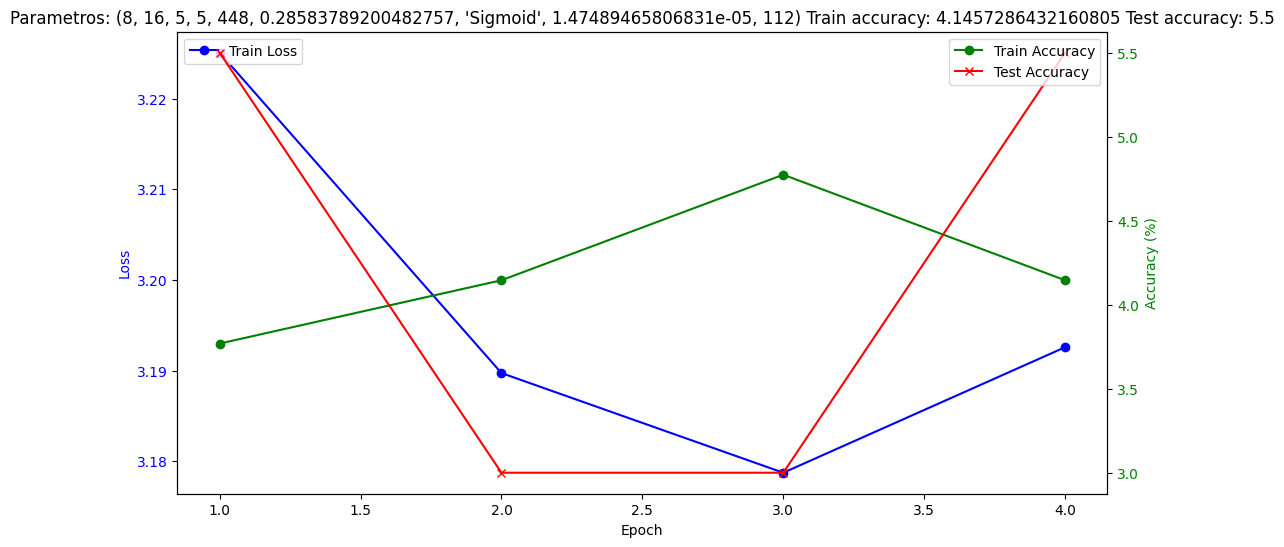

Epoch 1/10, Loss: 2.5937, Train Accuracy: 26.13%, Test Accuracy: 40.50%
Epoch 2/10, Loss: 2.1483, Train Accuracy: 43.34%, Test Accuracy: 46.50%
Epoch 3/10, Loss: 1.8999, Train Accuracy: 50.50%, Test Accuracy: 45.50%
Epoch 4/10, Loss: 1.7459, Train Accuracy: 54.27%, Test Accuracy: 56.50%
Epoch 5/10, Loss: 1.6367, Train Accuracy: 55.03%, Test Accuracy: 55.00%
Epoch 6/10, Loss: 1.5252, Train Accuracy: 60.68%, Test Accuracy: 61.50%
Epoch 7/10, Loss: 1.4594, Train Accuracy: 61.81%, Test Accuracy: 54.50%
Epoch 8/10, Loss: 1.4601, Train Accuracy: 60.43%, Test Accuracy: 60.50%
Epoch 9/10, Loss: 1.3736, Train Accuracy: 61.81%, Test Accuracy: 62.50%
Epoch 10/10, Loss: 1.3481, Train Accuracy: 62.56%, Test Accuracy: 54.00%


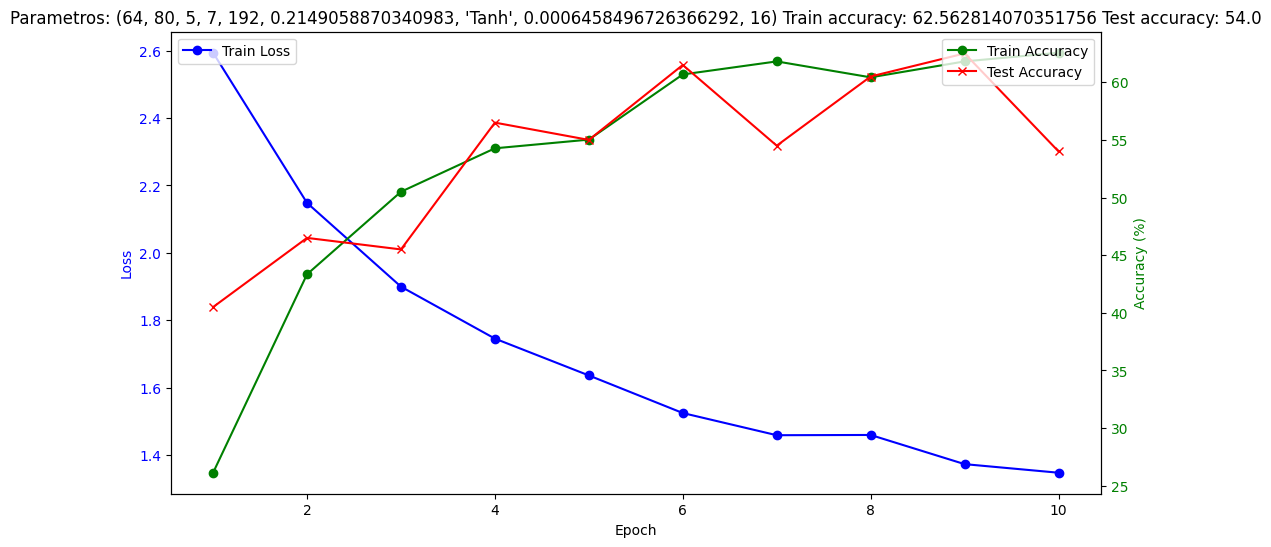

Epoch 1/10, Loss: 2.0577, Train Accuracy: 45.10%, Test Accuracy: 70.00%
Epoch 2/10, Loss: 0.8628, Train Accuracy: 80.65%, Test Accuracy: 76.50%
Epoch 3/10, Loss: 0.5216, Train Accuracy: 90.58%, Test Accuracy: 81.00%
Epoch 4/10, Loss: 0.3318, Train Accuracy: 94.10%, Test Accuracy: 81.50%
Epoch 5/10, Loss: 0.2344, Train Accuracy: 95.73%, Test Accuracy: 80.50%
Epoch 6/10, Loss: 0.1680, Train Accuracy: 98.37%, Test Accuracy: 83.50%
Epoch 7/10, Loss: 0.1195, Train Accuracy: 98.62%, Test Accuracy: 83.50%
Epoch 8/10, Loss: 0.0871, Train Accuracy: 98.99%, Test Accuracy: 84.50%
Epoch 9/10, Loss: 0.0671, Train Accuracy: 99.75%, Test Accuracy: 83.50%
Epoch 10/10, Loss: 0.0513, Train Accuracy: 99.75%, Test Accuracy: 84.50%


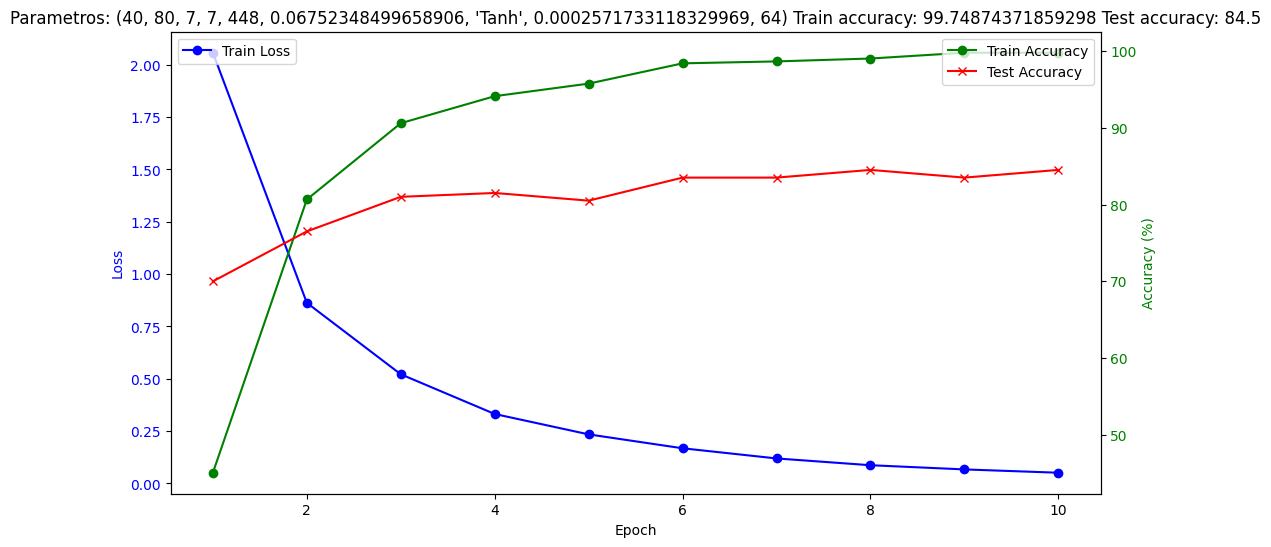

In [ ]:
# Entrenamiento y evaluación
accuracies = {}
train_losses = {}
train_accuracies = {}

for trial in study.trials:
    # Extraer los mejores hiperparámetros
    params = trial.params
    num_filters_conv1 = params['num_filters_conv1']
    num_filters_conv2 = params['num_filters_conv2']
    kernel_size_conv1 = params['kernel_size_conv1']
    kernel_size_conv2 = params['kernel_size_conv2']
    fc1_units = params['fc1_units']
    dropout_rate = params['dropout_rate']
    activation = params['activation']
    lr = params['lr']
    batch_size = params['batch_size']
    
    # Definir el modelo
    model = ConvNet(
        num_filters_conv1=num_filters_conv1,
        num_filters_conv2=num_filters_conv2,
        kernel_size_conv1=kernel_size_conv1,
        kernel_size_conv2=kernel_size_conv2,
        fc1_units=fc1_units,
        dropout_rate=dropout_rate,
        activation=activation
    )

    # Definir el dispositivo (GPU si está disponible, sino CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Mover el modelo al dispositivo correspondiente

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Cargar los datos con el batch_size correspondiente
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Inicializar métricas
    epoch_train_losses = []
    epoch_train_accuracies = []  # Lista para almacenar la precisión de entrenamiento
    epoch_accuracies = []

    epochs = 10
    
    # Parámetros de Early Stopping
    min_accuracy = 90.0  # Umbral mínimo de precisión en el conjunto de prueba (%)
    patience = 3         # Número de épocas consecutivas sin mejora significativa permitidas

    # Variables de Early Stopping
    best_accuracy = 0.0
    no_improvement_count = 0

    # Entrenamiento con Early Stopping
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Bucle de entrenamiento
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos al dispositivo
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calcular precisión en el entrenamiento
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calcular métricas de la época
        average_loss = running_loss / len(train_loader)
        epoch_train_losses.append(average_loss)
        train_accuracy = correct_train / total_train * 100
        epoch_train_accuracies.append(train_accuracy)

        # Evaluar en el conjunto de prueba
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Mover datos al dispositivo
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total * 100
        epoch_accuracies.append(test_accuracy)

        # Early Stopping Logic
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            no_improvement_count = 0  # Reiniciar contador si hay mejora
        else:
            no_improvement_count += 1

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        # Verificar condiciones de parada
        if best_accuracy >= min_accuracy:
            print(f"Deteniendo entrenamiento: Test Accuracy alcanzó el mínimo requerido de {min_accuracy}%")
            break
        if no_improvement_count >= patience:
            print(f"Deteniendo entrenamiento: No hubo mejora en las últimas {patience} épocas.")
            break


    # Guardar métricas
    key = (num_filters_conv1, num_filters_conv2, kernel_size_conv1, kernel_size_conv2, fc1_units, dropout_rate, activation.__name__, lr, batch_size)
    accuracies[key] = epoch_accuracies
    train_losses[key] = epoch_train_losses
    train_accuracies[key] = epoch_train_accuracies  # Guardar la precisión de entrenamiento

    trained_epochs = len(epoch_train_losses)

    # Gráfico de Loss y Accuracy
    plt.figure(figsize=(12, 6))

    # Pérdida
    ax1 = plt.gca()  # Obtener el eje izquierdo
    ax1.plot(range(1, trained_epochs + 1), epoch_train_losses, label='Train Loss', color='blue', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Precisión
    ax2 = ax1.twinx()  # Crear un segundo eje y
    ax2.plot(range(1, trained_epochs + 1), epoch_train_accuracies, label='Train Accuracy', color='green', marker='o')
    ax2.plot(range(1, trained_epochs + 1), epoch_accuracies, label='Test Accuracy', color='red', marker='x')
    ax2.set_ylabel('Accuracy (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    plt.title(f"Parametros: {key} Train accuracy: {epoch_train_accuracies[-1]} Test accuracy: {epoch_accuracies[-1]}")
    plt.show()
#Entender como afecta cada hiperparametro a los resultados y quedarnos con los dos mejores y explicarlos


# Aprendizaje por transferencia

In [ ]:
# Cargar el modelo VGG-16 preentrenado
model = models.vgg16(pretrained=True)

# Congelar las capas convolucionales (no entrenarlas)
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa (fully connected layer) para adaptarlo a tu tarea
# Asumimos que hay 'num_classes' clases en tu problema
num_classes = 124  # Cambia esto según tu número de clases
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Solo optimizar la última capa

# Entrenamiento del modelo
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcular precisión
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

val_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {val_accuracy:.2f}%")

c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 3.2025, Accuracy: 17.71%
Epoch 2/5, Loss: 1.6907, Accuracy: 52.26%
Epoch 3/5, Loss: 1.2454, Accuracy: 65.83%
Epoch 4/5, Loss: 0.9740, Accuracy: 74.37%
Epoch 5/5, Loss: 0.8100, Accuracy: 79.02%
Test Accuracy: 51.00%


# Por hacer:
### a la hora de hacer la documentacion testear a mano el numero de epochs, capas convolucionales y capas fully connected en el entrenamiento y test basico y ed ahi nos quedamos con la configuracion para el optuna